**Table of contents**<a id='toc0_'></a>    
- 1. [Count earthquakes around tremor in Nankai       ](#toc1_)    
- 2. [Load data      ](#toc2_)    
  - 2.1. [Load earthquake catalog      ](#toc2_1_)    
  - 2.2. [Load tremor catalog      ](#toc2_2_)    
- 3. [Trim earthquake catalog  ](#toc3_)    
- 4. [Count earthquakes arond tremor ](#toc4_)    
  - 4.1. [Ball-tree counting (approximate)](#toc4_1_)    
    - 4.1.1. [Compute number of earthquakes at triggering distance    ](#toc4_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Count earthquakes around tremor in Nankai        [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

In [2]:
# Geographic distance
def distance(lon1, lat1, z1, lon2, lat2, z2):
    # Convert degrees to radians
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)

    # Compute differences in longitude and latitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance_km = 6371 * c

    distance_km = np.sqrt(distance_km**2 + (z2 - z1)**2)

    return distance_km

# 2. <a id='toc2_'></a>Load data       [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog       [&#128285;](#toc0_)

In [3]:
# Directly load catalog from csv
eq = pd.read_csv(workdir + 'projects/data/Catalogs/JMA/eq_2000_2021.csv', parse_dates=['date'])
print('{:d} events in the catalog'.format(len(eq)))

3801905 events in the catalog


## 2.2. <a id='toc2_2_'></a>Load tremor catalog       [&#128285;](#toc0_)

In [4]:
# Load data
path = workdir + 'projects/data/Catalogs/world_tremor_database/nankai_wtb_0413_clust.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
trm = pd.read_csv(
    path,
    names=COLS,
)

trm['date_str'] = trm.date.values + ' ' + trm.time.values
trm['date'] = pd.to_datetime(trm.date_str)
day0 = np.datetime64('2004-01-01')
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

trm.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(trm.shape[0], trm.date.min().year, trm.date.max().year))

55127 tremor detections, spanning 2004--2013


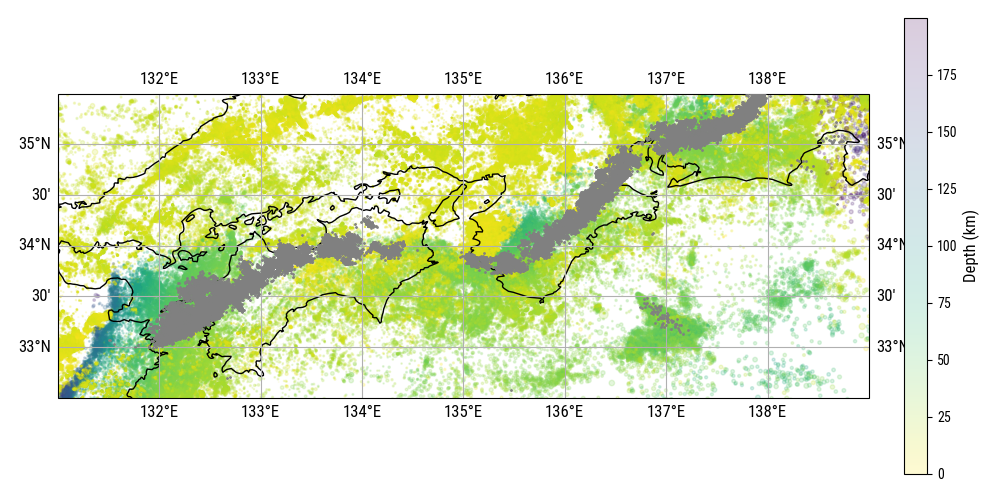

In [5]:
# Plot it
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([131, 139, 32.5, 35.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree(), zorder=10)
sc = ax.scatter(eq.lon[eq.depth<200], eq.lat[eq.depth<200], s=eq.mag[eq.depth<200]**2, c=eq.depth[eq.depth<200], transform=ccrs.PlateCarree(), alpha=.2, cmap='viridis_r')
plt.colorbar(sc, label='Depth (km)', pad=0.04, fraction=0.046)

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Trim catalogs   [&#128285;](#toc0_)

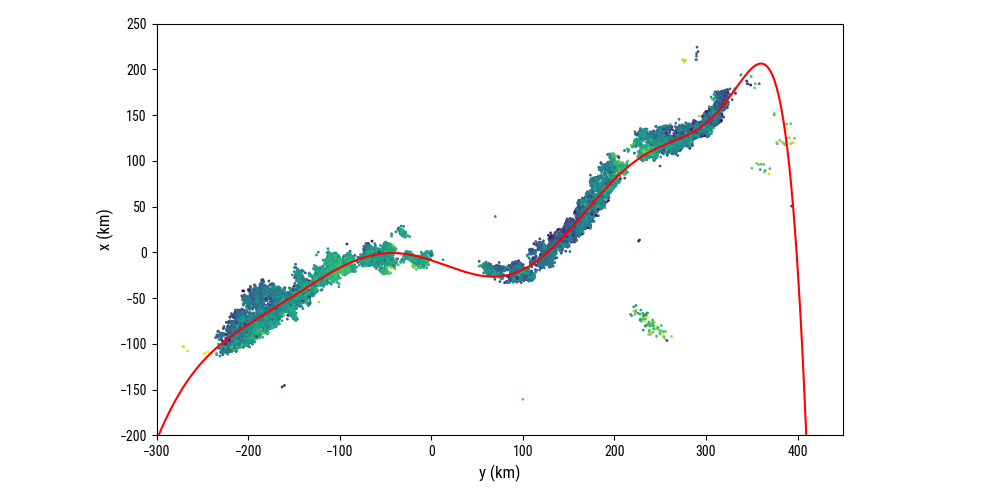

In [7]:
# Define strike
# --> Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000

# Define along-strike: fit a polynomial to the tremor line
p_strike = np.polyfit(trm.x, trm.y, 10)

# Show
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')

ax.scatter(trm.x, trm.y, s=1, c=trm.depth, cmap='viridis_r')

x = np.arange(-350, 600, 1)
y = np.polyval(p_strike, x)
ax.plot(x, y, 'r', zorder=10)

ax.set_xlim(-300, 450)
ax.set_ylim(-200, 250)

plt.tight_layout()
plt.show()

In [8]:
# Project along-strike: nearest point from each event to the strike line
# --> Define a strike line with evenly spaced points along it
x0, y0 = -300, np.polyval(p_strike, -300)   # initial point
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
x = x0
while x < 400:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dx = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), x))**2)
    x += dx
    y = np.polyval(p_strike, x)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor
from scipy.spatial import cKDTree

tree = cKDTree(np.column_stack((X, Y)))
trm_across_strike_dist, trm_nearest_idx = tree.query(np.column_stack((trm.x, trm.y)))

trm_along_strike_dist = S[trm_nearest_idx]

trm['xf'] = trm_along_strike_dist
trm['yf'] = trm_across_strike_dist

# # Show
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('x (km)')  
#     ax.set_ylabel('y (km)')
#     ax.plot(X, Y, 'r', zorder=10)

# # axes[0].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
# axes[0].scatter(trm.x, trm.y, s=1, c=trm_along_strike_dist, cmap='viridis', vmin=0, vmax=1000)

# # axes[1].scatter(eq.x, eq.y, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
# axes[1].scatter(trm.x, trm.y, s=1, c=trm_across_strike_dist, cmap='viridis', vmax=50)

# plt.tight_layout()
# plt.show()

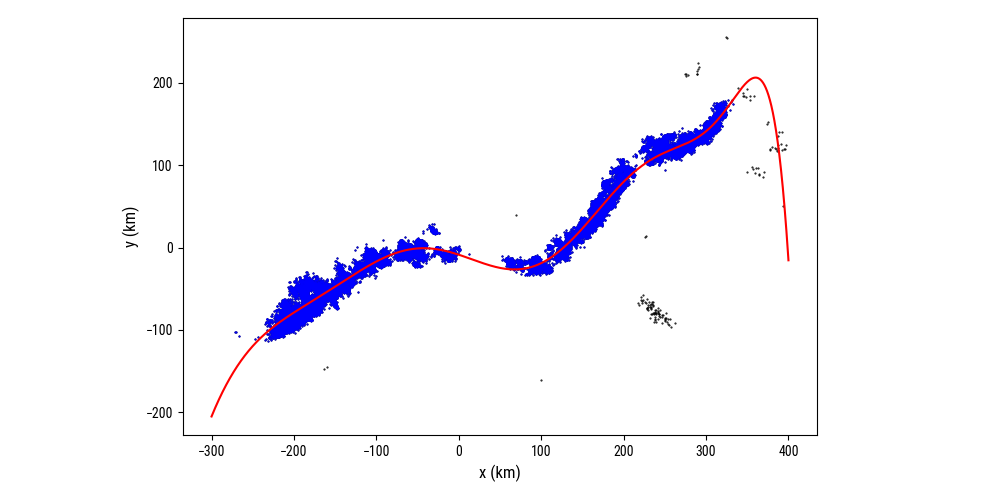

In [9]:
# Trim
xf_max = 800
yf_max = 50

indicator = (trm.xf < xf_max) & (trm.yf < yf_max)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.plot(X, Y, 'r', zorder=10)
ax.plot(trm.x, trm.y, 'k.', ms=1)
ax.plot(trm.x[indicator], trm.y[indicator], 'b.', ms=1)

plt.tight_layout()
plt.show()

trm = trm[indicator]

In [47]:
# For earthquakes, select a smaller box than the full catalog, to reduce time
lon_min = 130
lon_max = 140
lat_min = 31
lat_max = 37

indicator = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max)
selected_eq = eq[indicator].copy()
print('{:d} events in the selected region'.format(len(selected_eq)))

# Project along-strike: nearest point from each event to the strike line (~1min for 1.7M events)
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((selected_eq.x, selected_eq.y)))
eq_along_strike_dist = S[eq_nearest_idx]

selected_eq['xf'] = eq_along_strike_dist  # xf or xfault: along-strike distance in km
selected_eq['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km

# # Show
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_aspect('equal')
# ax.set_xlabel('x (km)')
# ax.set_ylabel('y (km)')

# ax.plot(X, Y, 'r', zorder=10)
# ax.scatter(selected_eq.x, selected_eq.y, c=selected_eq.xf, s=1, zorder=1)
# ax.scatter(trm.x, trm.y, c='k', s=1, zorder=9)

# plt.tight_layout()
# plt.show()

1748822 events in the selected region


# 4. <a id='toc4_'></a>Count earthquakes arond tremor  [&#128285;](#toc0_)
Could improve:
- Count all earthquakes of the period instead of the ones during the 10 years of the catalog?

In [48]:
epicentral = False
brute_force = False

In [49]:
# Which earthquakes
interval = [np.datetime64('2004-01-01'), np.datetime64('2013-04-01')]

min_mag = 1.

selected_eq = selected_eq[(selected_eq.date >= interval[0]) & (selected_eq.date < interval[1]) & (selected_eq.mag >= min_mag)]
print('{:d} events in the selected region between {:s} and {:s} with magnitude >= {:s}'.format(len(selected_eq), str(interval[0]), str(interval[1]), str(min_mag)))

169153 events in the selected region between 2004-01-01 and 2013-04-01 with magnitude >= 1.0


## 4.1. <a id='toc4_1_'></a>Ball-tree counting (approximate) [&#128285;](#toc0_)
Looses accuracy as neighborhood is smaller.

In [50]:
# Compute the number of earthquakes at a close distance for each tremor (~40s for 80k events, 2min for 170k events)
from scipy.spatial import cKDTree

dists = [10, 20, 30, 50, 100]

n_eq = np.zeros((len(dists), len(trm)))   # number of earthquakes at given distance of each tremor event
eq_at_dist = np.zeros((len(dists), len(selected_eq))).astype(bool)  # boolean array to keep track of which earthquakes are within given distance from any tremor

# Build K-D trees
if epicentral:
    eq_tree = cKDTree(selected_eq[['x', 'y']].values)
    trm_tree = cKDTree(trm[['x', 'y']].values)
else:
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)

# Look for pairs of earthquakes and tremors within distance
for jj, dist in enumerate(dists):
    # Find earthquakes within distance of tremors
    eq_idx = trm_tree.query_ball_tree(eq_tree, dist)
    
    # --> How earthquakes at distance from tremor
    n_eq[jj, :] = np.array([len(e) for e in eq_idx])
    
    # --> Which ones
    eq_at_dist_idx = np.concatenate(eq_idx)
    eq_at_dist_idx = np.unique(eq_at_dist_idx).astype(int)
    eq_at_dist[jj, eq_at_dist_idx] = True

In [51]:
# Convert counts to rates per year
n_eq = n_eq / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

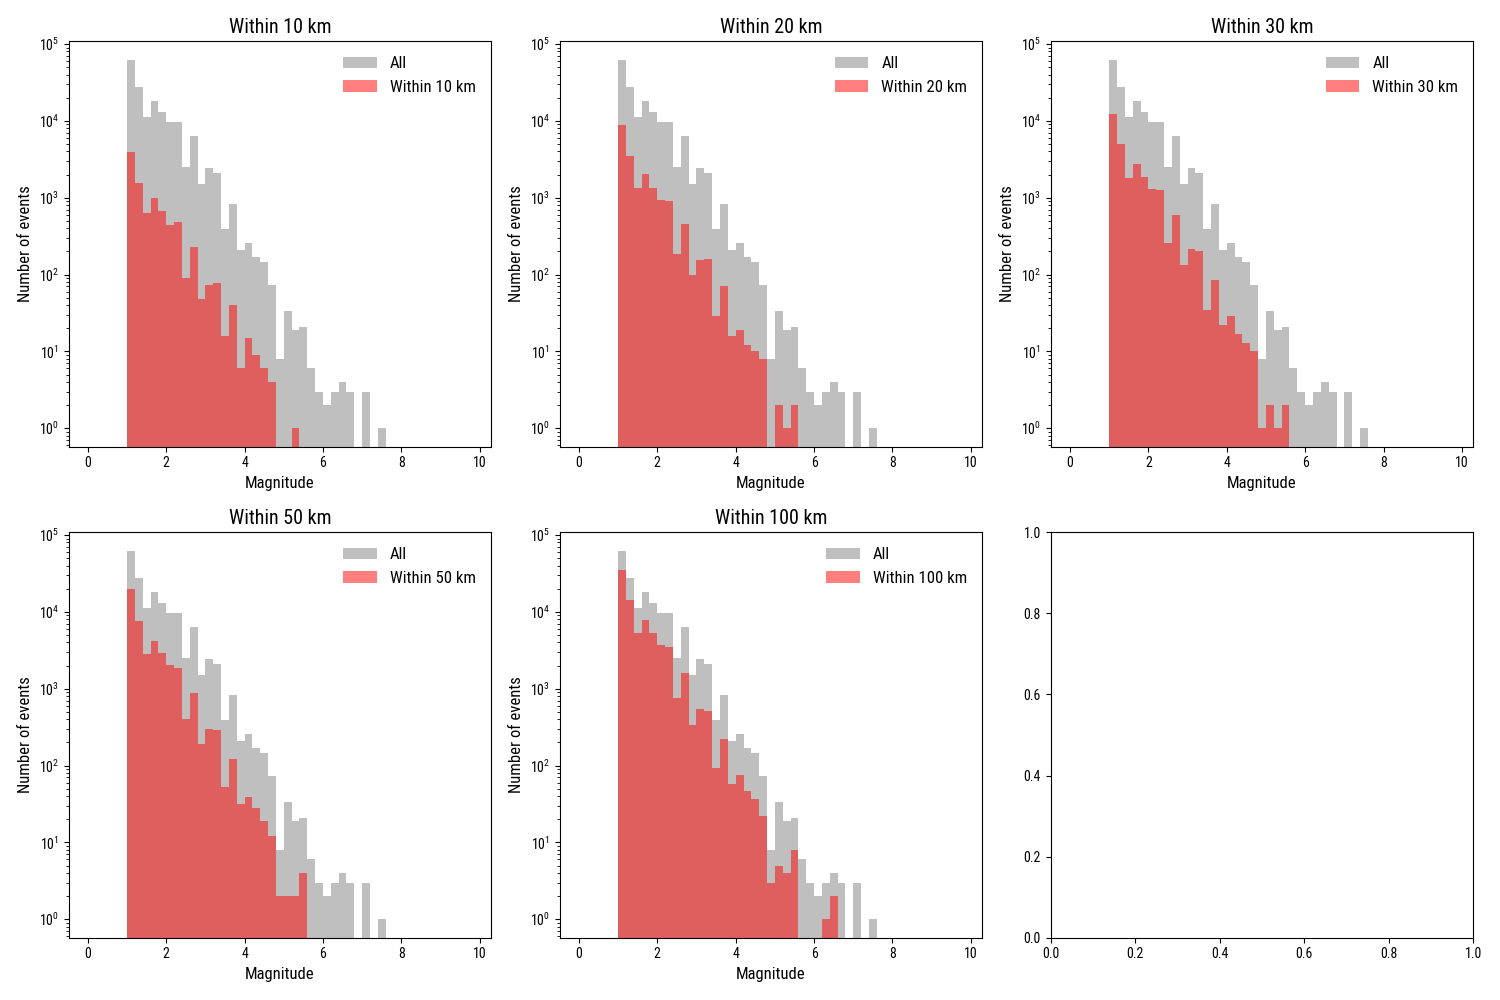

In [52]:
# Magnitude of completeness of each group
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for jj, dist in enumerate(dists):
    ax = axes.flat[jj]
    ax.hist(selected_eq.mag, bins=np.arange(0, 10, .2), color='gray', alpha=.5, label='All', zorder=0)
    ax.hist(selected_eq.mag[eq_at_dist[jj]], bins=np.arange(0, 10, .2), color='red', alpha=.5, label='Within {:d} km'.format(dist), zorder=1)
    ax.set_title('Within {:d} km'.format(dist))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of events')
    ax.set_yscale('log')
    ax.legend()
    
plt.tight_layout()
plt.show()

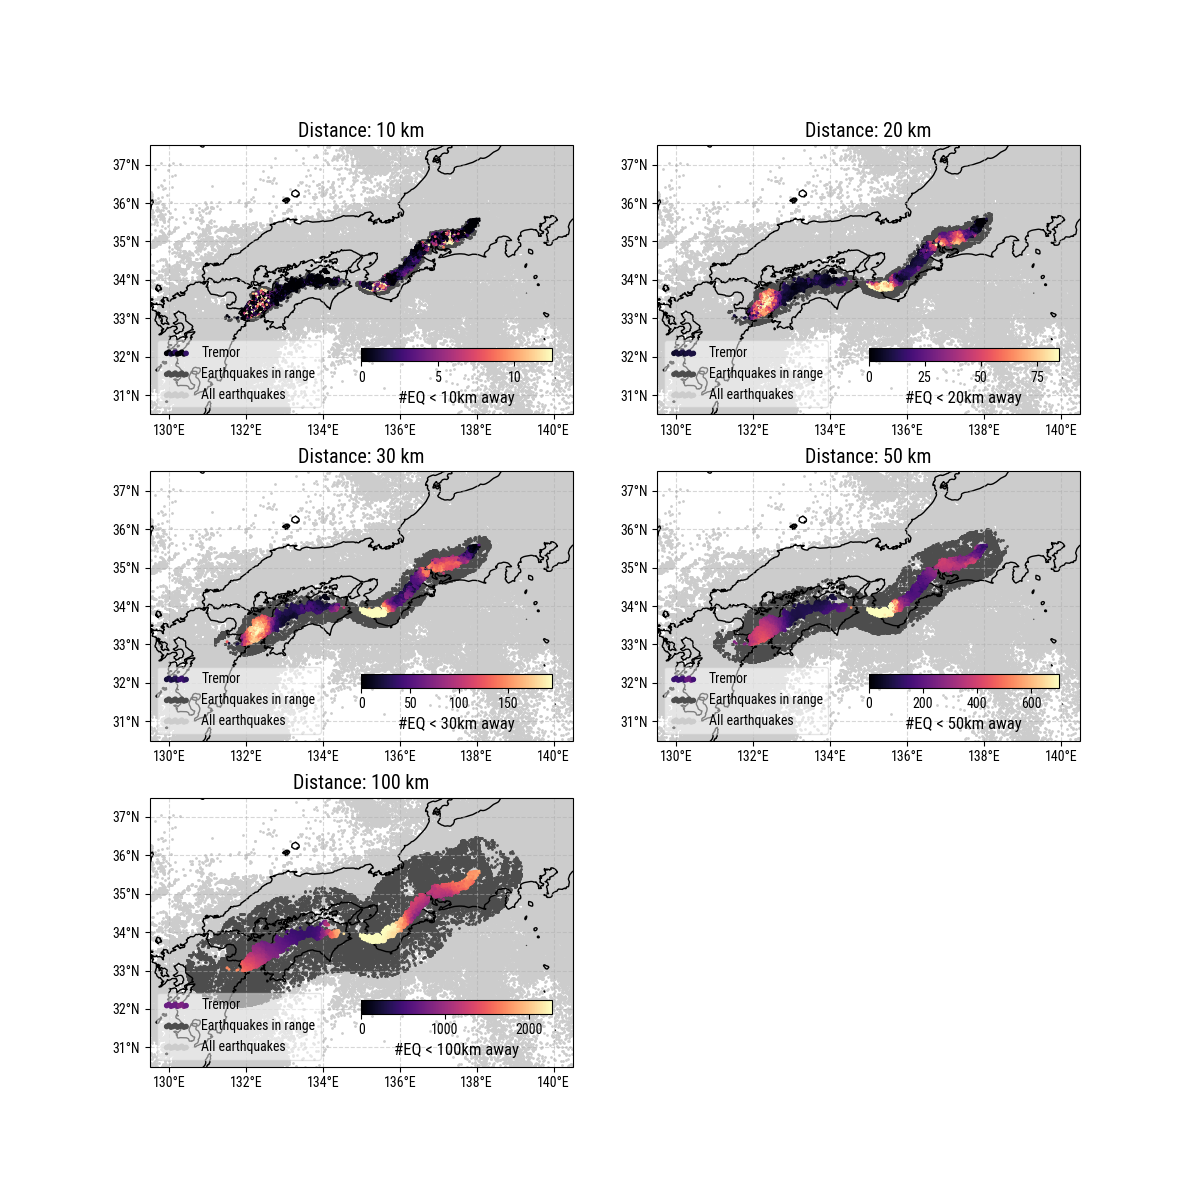

In [53]:
# Plot it
lon_min = 129.5
lon_max = 140.5
lat_min = 30.5
lat_max = 37.5
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 12))
axes = [plt.subplot(3, 2, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(dists)), axes):
    ax.set_title('Distance: {:d} km'.format(dists[ii]))
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=n_eq[ii, :], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(n_eq[ii, :], 95), zorder=2, label='Tremor')
    ax.scatter(selected_eq.lon[eq_at_dist[ii]], selected_eq.lat[eq_at_dist[ii]], c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(dists[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    ax.legend(loc='lower left', fontsize='small', framealpha=.5, scatterpoints=10, markerscale=3)

    # Colorbar
    x_min_ax = 0.5; y_min_ax = 0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb = fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb, orientation='horizontal', label="#EQ < {:d}km away".format(dists[ii]))

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

# plt.tight_layout()
plt.show()

In [54]:
# Save it
trm.loc[:, 'n_eq_10km'] = n_eq[0, :]
trm.loc[:, 'n_eq_20km'] = n_eq[1, :]
trm.loc[:, 'n_eq_30km'] = n_eq[2, :]
trm.loc[:, 'n_eq_50km'] = n_eq[3, :]
trm.loc[:, 'n_eq_100km'] = n_eq[4, :]

trm.to_csv('data/nankai/processed/nank_trm_clust_0104_0413_trim_eqdist_mc{:.1f}.csv'.format(min_mag), index=False)

# Save the earthquakes
selected_eq.loc[:, 'in10km'] = eq_at_dist[0, :]
selected_eq.loc[:, 'in20km'] = eq_at_dist[1, :]
selected_eq.loc[:, 'in30km'] = eq_at_dist[2, :]
selected_eq.loc[:, 'in50km'] = eq_at_dist[3, :]
selected_eq.loc[:, 'in100km'] = eq_at_dist[4, :]

selected_eq.to_csv('data/nankai/processed/nank_eqmc{:.1f}_0104_0413_trim_eqdist.csv'.format(min_mag), index=False)